In [8]:
"""Analyze saved baseline model results - NO RETRAINING."""

import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Configuration
RESULTS_DIR = Path("../results")
EXPERIMENT_NAMES = [
    "logistic_regression_with_rms",
    "logistic_regression_with_log_mel",
    "random_forest_with_rms",
    "random_forest_with_log_mel",
]

In [9]:
# Load all saved metrics
all_metrics = {}
for exp_name in EXPERIMENT_NAMES:
    metrics_path = RESULTS_DIR / exp_name / "metrics.json"
    if metrics_path.exists():
        with open(metrics_path) as f:
            all_metrics[exp_name] = json.load(f)
    else:
        print(f"Warning: {metrics_path} not found")

print(f"Loaded metrics for {len(all_metrics)} experiments")

Loaded metrics for 4 experiments


In [10]:
# 1. Overall Performance Comparison
print("=" * 70)
print("MODEL PERFORMANCE SUMMARY")
print("=" * 70)

summary_data = []
for exp_name, metrics in all_metrics.items():
    report = metrics["classification_report"]
    summary_data.append({
        "Model": exp_name.replace("_", " ").title(),
        "Accuracy": metrics["final_accuracy"],
        "Macro F1": report["macro avg"]["f1-score"],
        "Weighted F1": report["weighted avg"]["f1-score"],
        "N Classes": len([k for k in report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]),
        "Test Samples": int(report["macro avg"]["support"]),
    })

df_summary = pd.DataFrame(summary_data)
print(df_summary.to_string(index=False))
print("\n")

MODEL PERFORMANCE SUMMARY
                           Model  Accuracy  Macro F1  Weighted F1  N Classes  Test Samples
    Logistic Regression With Rms  0.175331  0.110832     0.117489         10           981
Logistic Regression With Log Mel  0.487258  0.482954     0.484299         10           981
          Random Forest With Rms  0.158002  0.151053     0.154150         10           981
      Random Forest With Log Mel  0.394495  0.390032     0.392087         10           981




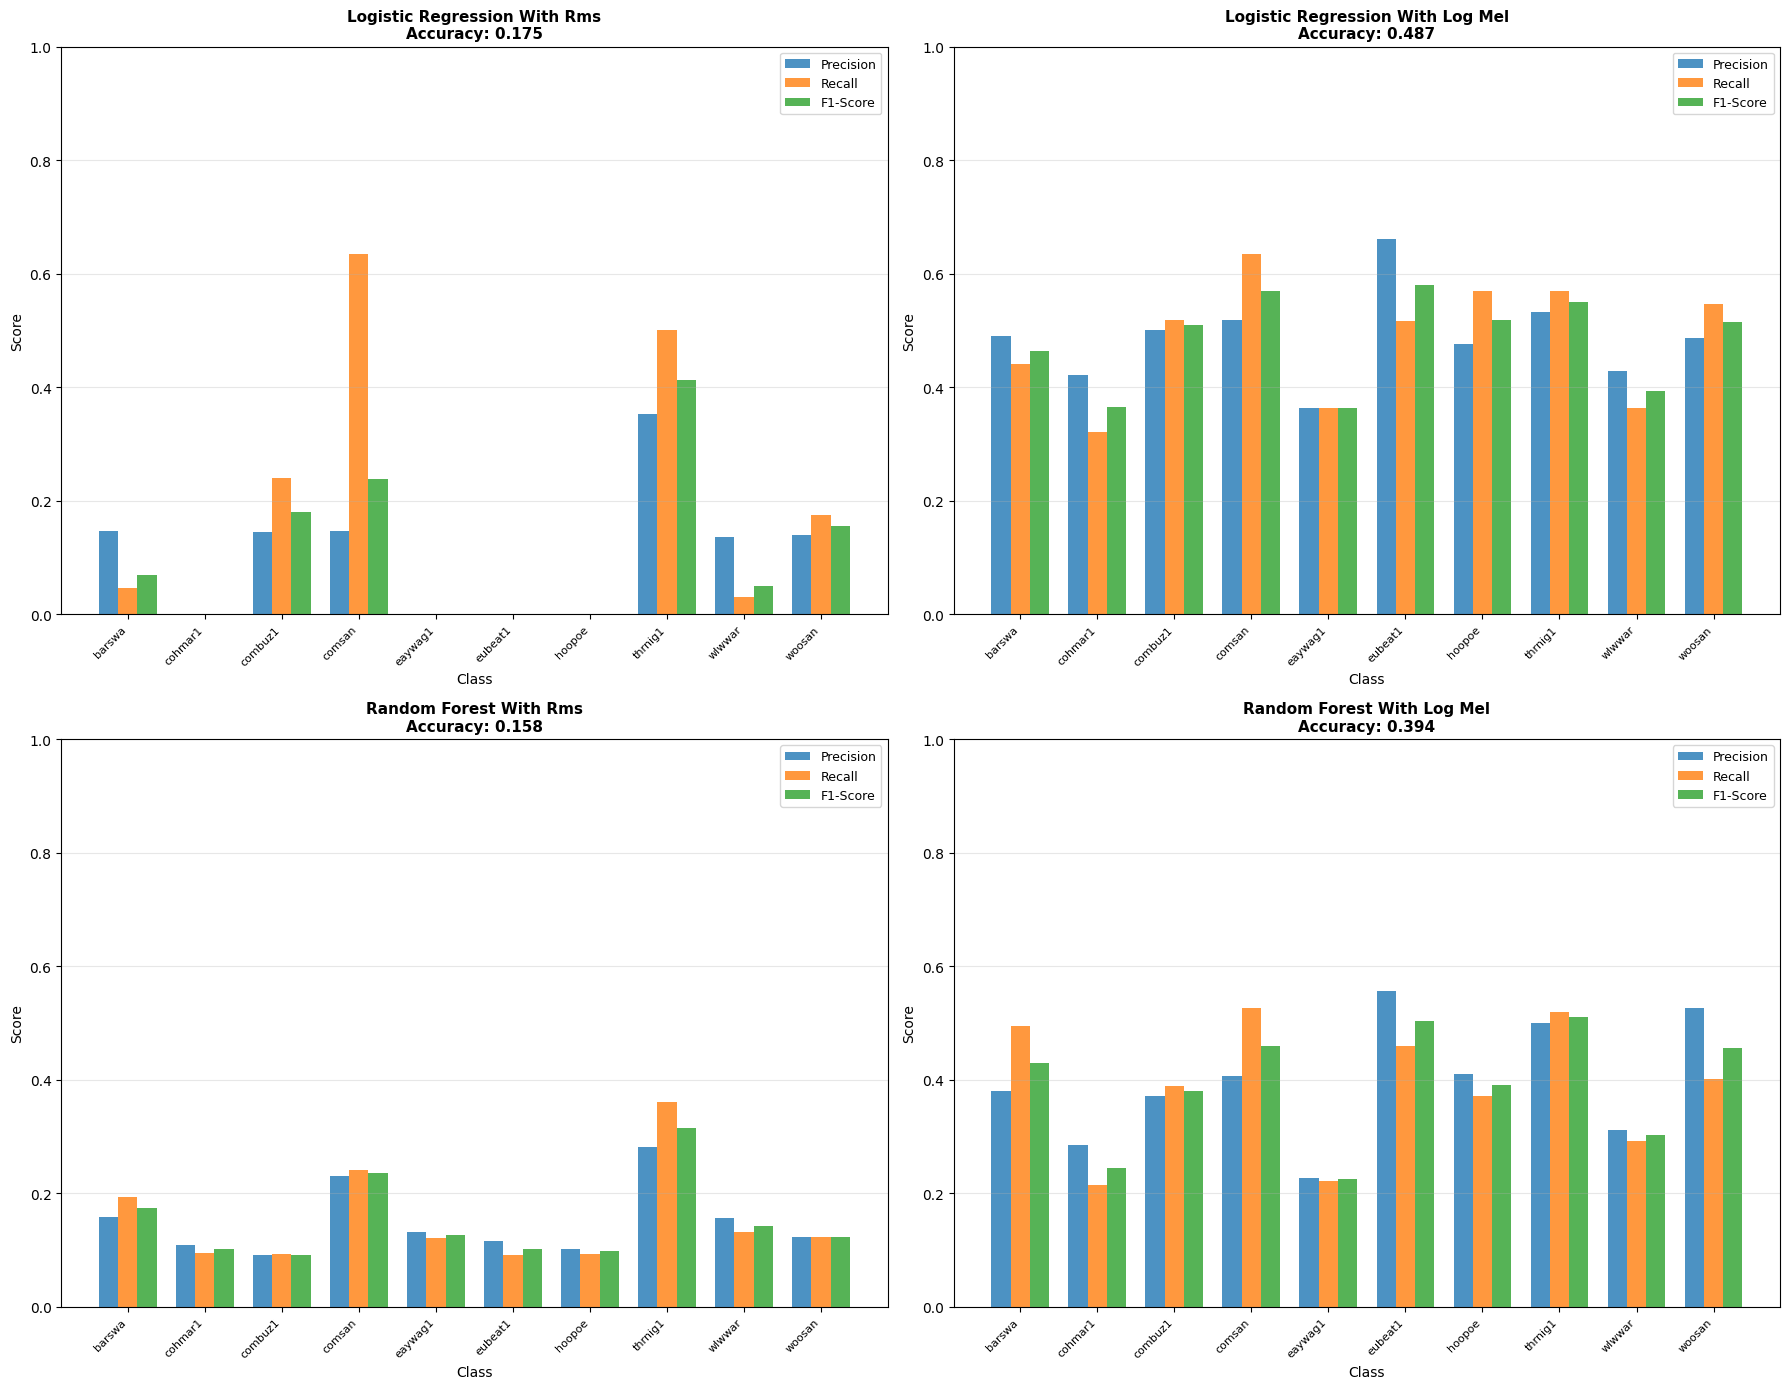

✓ Per-class performance saved to results/per_class_performance.png


In [11]:
# 2. Per-Class Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (exp_name, metrics) in enumerate(all_metrics.items()):
    report = metrics["classification_report"]
    
    # Extract per-class metrics
    classes = [k for k in report.keys() if k not in ["accuracy", "macro avg", "weighted avg"]]
    precision = [report[cls]["precision"] for cls in classes]
    recall = [report[cls]["recall"] for cls in classes]
    f1 = [report[cls]["f1-score"] for cls in classes]
    
    x = np.arange(len(classes))
    width = 0.25
    
    axes[idx].bar(x - width, precision, width, label='Precision', alpha=0.8)
    axes[idx].bar(x, recall, width, label='Recall', alpha=0.8)
    axes[idx].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    axes[idx].set_xlabel('Class', fontsize=10)
    axes[idx].set_ylabel('Score', fontsize=10)
    axes[idx].set_title(f"{exp_name.replace('_', ' ').title()}\nAccuracy: {metrics['final_accuracy']:.3f}", 
                        fontsize=11, fontweight='bold')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(classes, rotation=45, ha='right', fontsize=8)
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_ylim([0, 1])

plt.tight_layout()
plt.savefig(RESULTS_DIR / "per_class_performance.png", dpi=150, bbox_inches='tight')
plt.show()
print("✓ Per-class performance saved to results/per_class_performance.png")

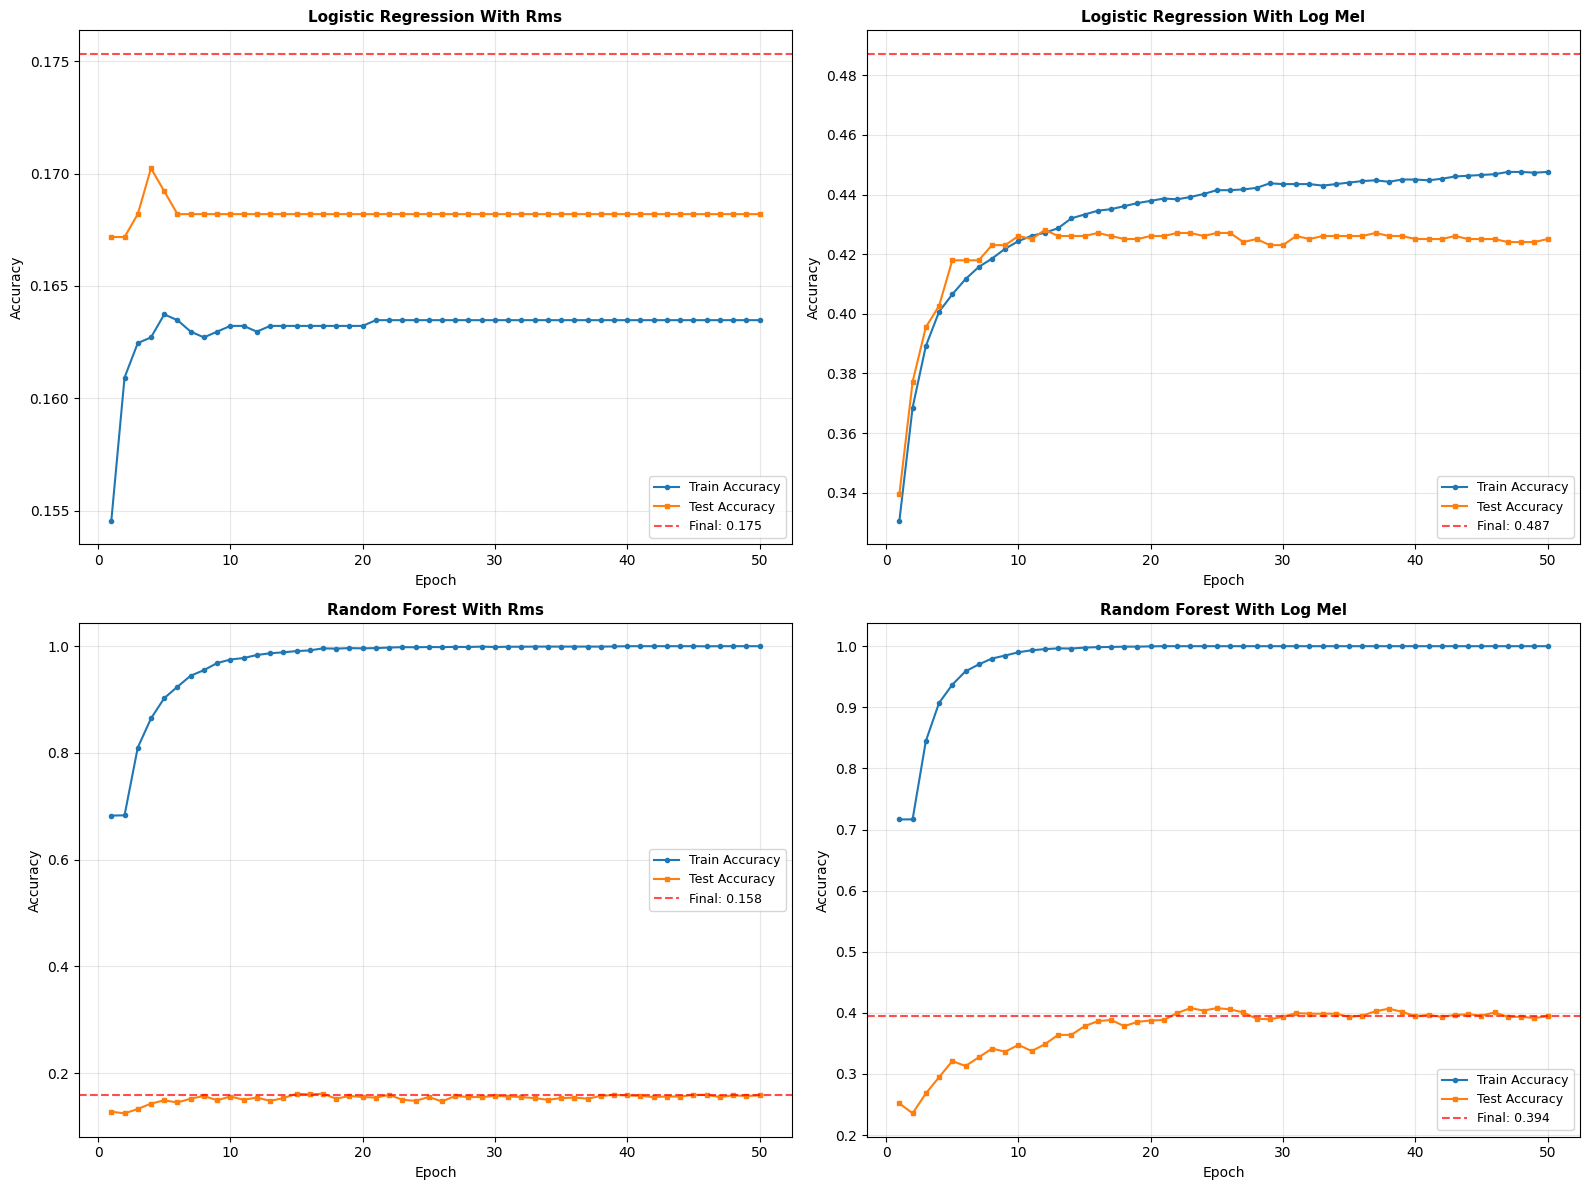

✓ Training progress saved to results/training_progress.png


In [12]:
# 3. Training Progress (Accuracy over Epochs)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, (exp_name, metrics) in enumerate(all_metrics.items()):
    train_accs = metrics["train_accuracies"]
    test_accs = metrics["test_accuracies"]
    epochs = range(1, len(train_accs) + 1)
    
    axes[idx].plot(epochs, train_accs, label="Train Accuracy", marker="o", markersize=3, linewidth=1.5)
    axes[idx].plot(epochs, test_accs, label="Test Accuracy", marker="s", markersize=3, linewidth=1.5)
    axes[idx].axhline(y=metrics["final_accuracy"], color='r', linestyle='--', 
                      label=f"Final: {metrics['final_accuracy']:.3f}", alpha=0.7)
    
    axes[idx].set_xlabel('Epoch', fontsize=10)
    axes[idx].set_ylabel('Accuracy', fontsize=10)
    axes[idx].set_title(f"{exp_name.replace('_', ' ').title()}", fontsize=11, fontweight='bold')
    axes[idx].legend(fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "training_progress.png", dpi=150, bbox_inches='tight')
plt.show()
print("✓ Training progress saved to results/training_progress.png")

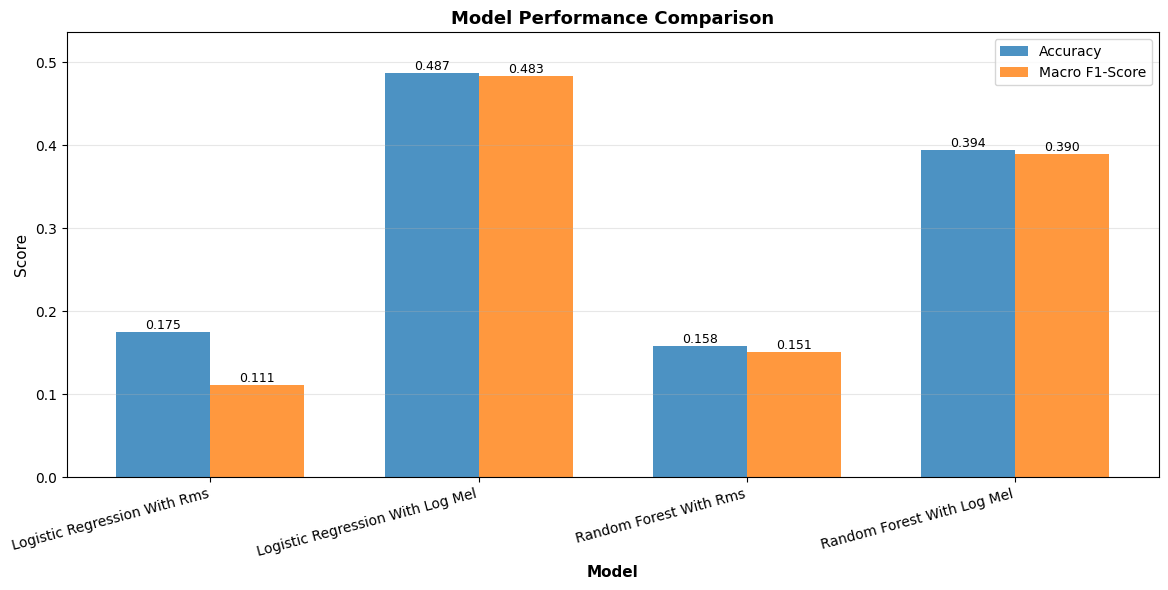

✓ Model comparison saved to results/model_comparison.png


In [13]:
# 4. Model Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))

models = [name.replace("_", " ").title() for name in all_metrics.keys()]
accuracies = [metrics["final_accuracy"] for metrics in all_metrics.values()]
macro_f1s = [metrics["classification_report"]["macro avg"]["f1-score"] for metrics in all_metrics.values()]

x = np.arange(len(models))
width = 0.35

bars1 = ax.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
bars2 = ax.bar(x + width/2, macro_f1s, width, label='Macro F1-Score', alpha=0.8)

ax.set_xlabel('Model', fontsize=11, fontweight='bold')
ax.set_ylabel('Score', fontsize=11)
ax.set_title('Model Performance Comparison', fontsize=13, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15, ha='right', fontsize=10)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, max(max(accuracies), max(macro_f1s)) * 1.1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()
print("✓ Model comparison saved to results/model_comparison.png")

In [14]:
# 5. Note about Confusion Matrix
print("=" * 70)
print("NOTE: CONFUSION MATRIX")
print("=" * 70)
print("""
To generate confusion matrices, test predictions need to be saved during training.
Currently, only metrics and classification reports are saved.

To add confusion matrix support:
1. Modify models.py _save_results() to save y_test and y_pred
2. Retrain models to generate predictions
3. Then confusion matrices can be created from saved predictions

For now, per-class performance metrics (precision, recall, F1) are available
in the classification reports, which provide similar insights.
""")

NOTE: CONFUSION MATRIX

To generate confusion matrices, test predictions need to be saved during training.
Currently, only metrics and classification reports are saved.

To add confusion matrix support:
1. Modify models.py _save_results() to save y_test and y_pred
2. Retrain models to generate predictions
3. Then confusion matrices can be created from saved predictions

For now, per-class performance metrics (precision, recall, F1) are available
in the classification reports, which provide similar insights.

